In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal
import datetime
import glob
import math
import sys

In [12]:
!pwd

/home/koepflma/project1/Mt-St-Helens/MtStHelens_activity


In [4]:
df_dome = pd.read_csv('dome_extrusion.txt', header=0, skiprows=0)
df_dome.set_index('Date of photography',inplace=True)
df_dome.index = pd.to_datetime(df_dome.index).tz_localize(None)
df_dome['diff'] = df_dome['Total volume change(x 106 m3)']-df_dome['Total volume change(x 106 m3)'].shift(1)
df_dome

,Total volume change(x 106 m3),Total volume change rate (m3/s),Extruded lava volume (x 106 m3),Lava extrusion rate (m3/s),diff
Date of photography,,,,,
2004-09-23,0,NaN,NaN,NaN,NaN
2004-10-04,5,NaN,NaN,NaN,5.0
2004-10-11,10,8.9,NaN,NaN,5.0
2004-10-13,11,6.4,0.54,NaN,1.0
2004-11-04,20,4.6,12.00,5.9,9.0
2004-11-29,27,3.0,21.00,4.4,7.0
2004-12-11,30,3.4,26.00,4.1,3.0
2005-01-03,35,2.4,31.00,2.5,5.0
2005-02-01,40,1.9,35.00,1.8,5.0


<Axes: xlabel='Date of photography'>

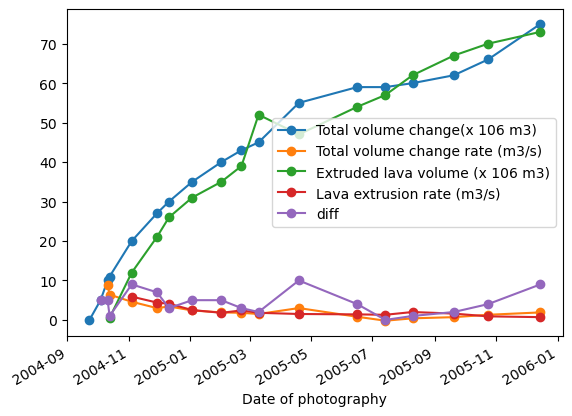

In [5]:
df_dome.plot(marker='o')

In [6]:
def mask_df(row):
    peaks, properties = scipy.signal.find_peaks(row, prominence=(row.rolling('10D').median()*100).to_numpy(), distance=len(row))
    row_masked = row.copy()
    try:
#         row_masked[row_masked>min(row_masked.iloc[properties['left_bases'][0]:properties['right_bases'][0]])]=np.nan
        row_masked.iloc[properties['left_bases'][0]-500:properties['right_bases'][0]+500]=np.nan
    except:
        pass
    return row_masked

def norm(s):
    diff_s = max(s)-min(s)
    s_norm = ((s - min(s))/diff_s)
    return s_norm

In [7]:
def distance(lat1, lat2, lon1, lon2):
    '''input: latitude and longitude of two points in degree
       output: distance between two points in kilometers'''
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = math.radians(lon1)
    lon2 = math.radians(lon2)
    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
 
    c = 2 * math.asin(math.sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)

In [8]:
# load station coordinates and drop the stations which are not of interresst
all_files = sorted(glob.glob('../RSAM_DSAR/data/*_*_extended2.csv'))
sta_list = np.unique([file.split('/')[3].split('_')[1] for file in all_files]) # stations with data

df = pd.read_csv('/home/koepflma/project1/Mt-St-Helens/sta_log_long.txt', sep='|', header=0) # coordinates
df = df[~df['Station'].isin(list(set(df.Station)-set(sta_list)))] # delete Stations which are not of interresst
df = df.drop_duplicates(subset=['Station']) # drop one station if the station is not unique
df = df.reset_index(drop=True)
df

,Network,Station,Latitude,Longitude,Elevation,Sitename,StartTime,EndTime
0,CC,BLIS,46.197472,-122.186569,2116.00,"Blister, Mt. St. Helens (Dome sta)",2004-10-12T00:00:00,2005-02-17T00:00:00
1,CC,HOA,46.241780,-122.191830,1151.00,Hoala,2021-06-08T00:00:00,2599-12-31T23:59:59
2,CC,JRO,46.275270,-122.218260,1219.00,Johnston Ridge Observatory,2004-10-02T00:00:00,2599-12-31T23:59:59
3,CC,LOO,46.223750,-122.184390,1521.35,Loowit,2021-06-08T00:00:00,2599-12-31T23:59:59
4,CC,MIDE,46.197750,-122.187439,2132.00,Near old BLIS MSH,2005-02-16T00:00:00,2005-07-26T00:00:00
5,CC,NED,46.200249,-122.185493,2060.00,"NE part of old Dome, Mt. St. Helens (Dome sta)",2004-11-20T00:00:00,2013-05-01T00:00:00
6,CC,RAFT,46.195679,-122.186317,2132.00,"RAFT, St Helens Crater",2005-07-28T00:00:00,2007-12-31T00:00:00
7,CC,REM,46.200200,-122.185500,1905.44,"Rembrant, Mount St. Helens",2018-07-25T00:00:00,2599-12-31T23:59:59
8,CC,SEP,46.199780,-122.190857,2114.00,"September lobe, Mt. St. Helens (Dome sta)",2004-11-05T00:00:00,2599-12-31T23:59:59
9,CC,SPN5,46.194698,-122.188370,2263.00,"Spine 5, St Helens Crater, WA",2007-06-18T00:00:00,2007-12-31T00:00:00


In [11]:
ref_sta = 'SEP' # define the reference station, we will get distance from all other stations to this station
df['dist'] = df.apply(lambda x: distance(x['Latitude'],df.Latitude[df['Station']==ref_sta] , x['Longitude'],df.Longitude[df['Station']==ref_sta] ), axis=1)
df = df.sort_values(by=['dist'])
sta_sorted = df['Station'].to_list()
df

,Network,Station,Latitude,Longitude,Elevation,Sitename,StartTime,EndTime,dist
8,CC,SEP,46.199780,-122.190857,2114.00,"September lobe, Mt. St. Helens (Dome sta)",2004-11-05T00:00:00,2599-12-31T23:59:59,0.000000
4,CC,MIDE,46.197750,-122.187439,2132.00,Near old BLIS MSH,2005-02-16T00:00:00,2005-07-26T00:00:00,0.346634
7,CC,REM,46.200200,-122.185500,1905.44,"Rembrant, Mount St. Helens",2018-07-25T00:00:00,2599-12-31T23:59:59,0.414926
5,CC,NED,46.200249,-122.185493,2060.00,"NE part of old Dome, Mt. St. Helens (Dome sta)",2004-11-20T00:00:00,2013-05-01T00:00:00,0.416109
0,CC,BLIS,46.197472,-122.186569,2116.00,"Blister, Mt. St. Helens (Dome sta)",2004-10-12T00:00:00,2005-02-17T00:00:00,0.418066
6,CC,RAFT,46.195679,-122.186317,2132.00,"RAFT, St Helens Crater",2005-07-28T00:00:00,2007-12-31T00:00:00,0.574494
9,CC,SPN5,46.194698,-122.188370,2263.00,"Spine 5, St Helens Crater, WA",2007-06-18T00:00:00,2007-12-31T00:00:00,0.596632
28,UW,YEL,46.209549,-122.188988,1750.00,"Yellow Rock, Mt. St. Helens",1981-10-01T00:00:00,2007-09-18T00:00:00,1.095744
12,CC,SWFL,46.188670,-122.202030,2268.00,Southwest Flank,2006-10-01T00:00:00,2013-08-28T00:00:00,1.505239
14,CC,VALT,46.214218,-122.189247,1681.00,"Vault, Mount St. Helens",2006-09-30T00:00:00,2599-12-31T23:59:59,1.610206


In [63]:
years = range(2000,2022+1)

df_rsam_median = pd.DataFrame(index=pd.date_range("{}-01-01".format(years[0]), "{}-01-01".format(years[-1]+1), freq="10min", inclusive='left'))
df_zscrsam_median = pd.DataFrame(index=pd.date_range("{}-01-01".format(years[0]), "{}-01-01".format(years[-1]+1), freq="10min", inclusive='left'))
df_dsar_median = pd.DataFrame(index=pd.date_range("{}-01-01".format(years[0]), "{}-01-01".format(years[-1]+1), freq="10min", inclusive='left'))
df_zscdsar_median = pd.DataFrame(index=pd.date_range("{}-01-01".format(years[0]), "{}-01-01".format(years[-1]+1), freq="10min", inclusive='left'))

df_rms_median = pd.DataFrame(index=pd.date_range("{}-01-01".format(years[0]), "{}-01-01".format(years[-1]+1), freq="10min", inclusive='left'))
df_zscrms_median = pd.DataFrame(index=pd.date_range("{}-01-01".format(years[0]), "{}-01-01".format(years[-1]+1), freq="10min", inclusive='left'))
df_pga_median = pd.DataFrame(index=pd.date_range("{}-01-01".format(years[0]), "{}-01-01".format(years[-1]+1), freq="10min", inclusive='left'))
df_zscpga_median = pd.DataFrame(index=pd.date_range("{}-01-01".format(years[0]), "{}-01-01".format(years[-1]+1), freq="10min", inclusive='left'))


len_dates = len(df_rsam_median)
count = 0

for i,sta in enumerate(sta_sorted):
    li = []
    len_data = 0
    for year in years:
        try:
            df = pd.read_csv('../RSAM_DSAR/data/{}_{}_extended2.csv'.format(year,sta))
        #     df = pd.read_csv('../data/{}_extended2_long.csv'.format(sta))
            df.set_index('time',inplace=True)
            df.index = pd.to_datetime(df.index).tz_localize(None)
            df = df.resample('10min').median()
            li.append(df)
            len_data += len(df.index)
        except:
#             print(' file {}_{}_extended2.csv does not exist'.format(year,sta))
            pass
    
    if len_data > len_dates*0.25: # percent of avivable data
        df = pd.concat(li)


        df = df.apply(mask_df,axis=0) # remove outliers (the peak detection does not work well)

        df = df.rolling('6H', center=True).median()
        df['rsam_median'] = df['rsam'].rolling('2D').median()
        df['zsc2_rsam_median'] = df['zsc2_rsam'].rolling('2D').median()
        df['dsar_median'] = df['dsar'].rolling('2D').median()
        df['zsc2_dsar_median'] = df['zsc2_dsar'].rolling('2D').median()
        df['rms_median'] = df['rms'].rolling('2D').median()
        df['zsc2_rms_median'] = df['zsc2_rms'].rolling('2D').median()
        df['pga_median'] = df['pga'].rolling('2D').median()
        df['zsc2_pga_median'] = df['zsc2_pga'].rolling('2D').median()
    #     df = df.resample('1H').median()

        df = df.apply(norm,axis=0) # normalize all timesiries individual

        df += count*0.5 # to get offset

        df_rsam_median['{}'.format(sta)] = df['rsam_median']
        df_zscrsam_median['{}'.format(sta)] = df['zsc2_rsam_median']
        df_dsar_median['{}'.format(sta)] = df['dsar_median']
        df_zscdsar_median['{}'.format(sta)] = df['zsc2_dsar_median']

        df_rms_median['{}'.format(sta)] = df['rms_median']
        df_zscrms_median['{}'.format(sta)] = df['zsc2_rms_median']
        df_pga_median['{}'.format(sta)] = df['pga_median']
        df_zscpga_median['{}'.format(sta)] = df['zsc2_pga_median']
        
        count += 1
    else:
        pass
    
    sys.stdout.write('\r{} of {}'.format(i+1, len(sta_list)))
    sys.stdout.flush()
print('\nDONE')

7 of 25

/tmp/ipykernel_1949194/930424552.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index).tz_localize(None)


9 of 25

/tmp/ipykernel_1949194/930424552.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index).tz_localize(None)


12 of 25

/tmp/ipykernel_1949194/930424552.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index).tz_localize(None)


13 of 25

/tmp/ipykernel_1949194/930424552.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index).tz_localize(None)


14 of 25

/tmp/ipykernel_1949194/930424552.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index).tz_localize(None)


17 of 25

/tmp/ipykernel_1949194/930424552.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index).tz_localize(None)


18 of 25

/tmp/ipykernel_1949194/930424552.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index).tz_localize(None)


23 of 25

/tmp/ipykernel_1949194/930424552.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index).tz_localize(None)


24 of 25

/tmp/ipykernel_1949194/930424552.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index).tz_localize(None)


25 of 25
DONE


In [435]:
df_dsar_test = df_dsar_median.loc['2006']
df_dsar_test

,SEP,NED,YEL,VALT,HSR,EDM,SHW,STD,SOS,JUN,JRO,FL2,CDF,ELK,TDL
2006-01-01 00:00:00,0.357149,1.107881,1.521166,NaN,2.368581,3.213417,3.363916,4.384826,4.508578,4.591678,NaN,5.855866,6.241975,6.734214,7.175302
2006-01-01 00:10:00,0.357149,1.107881,1.521166,NaN,2.368341,3.213417,3.363916,4.384826,4.514427,4.591678,NaN,5.856750,6.241975,6.734849,7.175501
2006-01-01 00:20:00,0.357149,1.109511,1.521166,NaN,2.368096,3.213417,3.363959,4.384826,4.517114,4.591457,NaN,5.856750,6.241975,6.735341,7.175757
2006-01-01 00:30:00,0.357149,1.111141,1.521166,NaN,2.368079,3.213417,3.364532,4.384988,4.521149,4.591442,NaN,5.856750,6.241975,6.735960,7.177223
2006-01-01 00:40:00,0.357149,1.111141,1.521166,NaN,2.368079,3.213417,3.365553,4.385184,4.523996,4.591174,NaN,5.856750,6.241975,6.739224,7.178679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006-12-31 23:10:00,NaN,NaN,1.097147,NaN,2.240604,2.857533,3.999996,4.052904,4.348258,4.544885,NaN,5.751234,6.243719,6.851251,7.232099
2006-12-31 23:20:00,NaN,NaN,1.097147,NaN,2.240604,2.857517,3.999996,4.052857,4.348258,4.544885,NaN,5.751126,6.243257,6.850735,7.232099
2006-12-31 23:30:00,NaN,NaN,1.097100,NaN,2.240604,2.857300,3.999996,4.052614,4.348258,4.544885,NaN,5.750970,6.243185,6.850536,7.232001
2006-12-31 23:40:00,NaN,NaN,1.097052,NaN,2.240604,2.857083,3.999996,4.052418,4.348258,4.544885,NaN,5.750922,6.243104,6.850495,7.231902


In [436]:
df_dsar_median

,SEP,NED,YEL,VALT,HSR,EDM,SHW,STD,SOS,JUN,JRO,FL2,CDF,ELK,TDL
2000-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01 00:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 23:10:00,0.332245,NaN,NaN,1.632268,2.152256,3.001283,3.216082,3.512935,4.254629,NaN,NaN,5.882669,6.236548,6.819596,7.263564
2022-12-31 23:20:00,0.331862,NaN,NaN,1.631850,2.152256,3.001283,3.215905,3.512935,4.254629,NaN,NaN,5.882669,6.236472,6.819596,7.260284
2022-12-31 23:30:00,0.331388,NaN,NaN,1.631309,2.152022,3.001283,3.215643,3.512935,4.254629,NaN,NaN,5.882669,6.236214,6.819596,7.259903
2022-12-31 23:40:00,0.331074,NaN,NaN,1.630752,2.151200,3.001283,3.215292,3.513071,4.254629,NaN,NaN,5.882669,6.235956,6.819596,7.259903


## Stack DSAR

### includ all years in stack

In [220]:
# Creating a dictionary inclding all years
df_dict = {}

for year in years:
    df_year = df_dsar_median.loc[str(year)] # splits df into samaller df for each year
    df_split1 = df_year[df_year.index<datetime.datetime(year,2,28,23,59,59,999)] # inclued dates until 28.2
    df_split2 = df_year[df_year.index>datetime.datetime(year,3,1)] # includes dates from 1.3
    df_concat = pd.concat([df_split1, df_split2]) # concat so that 29.2 removed
    df_dict[year] = df_concat # add shorted years to dict

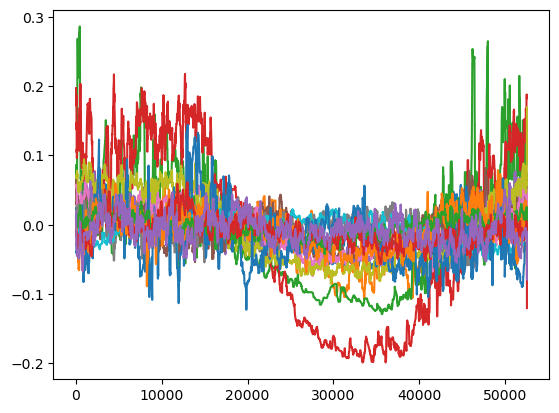

In [235]:
plt.plot(stack) # old

In [ ]:
df_list = []

arr_all = np.full((len(years), df_dict[years[0]].shape[0], df_dict[years[0]].shape[1]), np.nan)
for i,key in enumerate(df_dict.keys()):
    arr = df_dict[key].to_numpy()
    arr = arr - np.nanmean(arr, axis=0)
    arr_all[i,:,:] = arr
stack = np.nanmean(arr_all, axis=0)

for i,key in enumerate(df_dict.keys()):
    new_data_arr = df_dict[key].to_numpy()-stack
    df_list.append(pd.DataFrame(data=new_data_arr, index=df_dict[key].index, columns=df_dict[key].columns))
df_all_new = pd.concat(df_list)

### exclude eruption

In [220]:
# Creating a dictionary
df_dict = {}

for year in years:
# for year in [2001,2002,2003,2009,2010,2011,2013,2014,2015,2017,2018,2019,2021,2022]:
    df_year = df_dsar_median.loc[str(year)] # splits df into samaller df for each year
    df_split1 = df_year[df_year.index<datetime.datetime(year,2,28,23,59,59,999)] # inclued dates until 28.2
    df_split2 = df_year[df_year.index>datetime.datetime(year,3,1)] # includes dates from 1.3
    df_concat = pd.concat([df_split1, df_split2]) # concat so that 29.2 removed
    df_dict[year] = df_concat # add shorted years to dict

df_dict_full = {}    
for year in years:
    df_year = df_dsar_median.loc[str(year)] # splits df into samaller df for each year
    df_split1 = df_year[df_year.index<datetime.datetime(year,2,28,23,59,59,999)] # inclued dates until 28.2
    df_split2 = df_year[df_year.index>datetime.datetime(year,3,1)] # includes dates from 1.3
    df_concat = pd.concat([df_split1, df_split2]) # concat so that 29.2 removed
    df_dict_full[year] = df_concat # add shorted years to dict

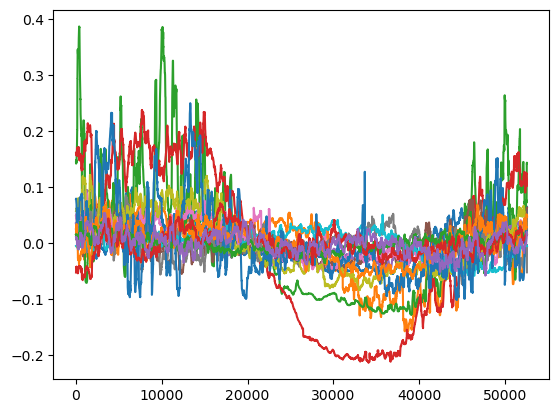

In [252]:
plt.plot(stack) # new without eruption

In [243]:
df_list = []

# arr_all = np.full((len(years), df_dict[years[0]].shape[0], df_dict[years[0]].shape[1]), np.nan)
arr_all = np.full((len(df_dict), df_dict[list(df_dict.keys())[0]].shape[0], df_dict[list(df_dict.keys())[0]].shape[1]), np.nan)
for i,key in enumerate(df_dict.keys()):
    arr = df_dict[key].to_numpy()
    arr = arr - np.nanmean(arr, axis=0)
    arr_all[i,:,:] = arr
stack = np.nanmean(arr_all, axis=0)

for i,key in enumerate(df_dict_full.keys()):
    new_data_arr = df_dict_full[key].to_numpy()-stack
    df_list.append(pd.DataFrame(data=new_data_arr, index=df_dict_full[key].index, columns=df_dict_full[key].columns))
df_all_new = pd.concat(df_list)

/tmp/ipykernel_1949194/1213782473.py:7: RuntimeWarning: Mean of empty slice
  arr = arr - np.nanmean(arr, axis=0)
/tmp/ipykernel_1949194/1213782473.py:9: RuntimeWarning: Mean of empty slice
  stack = np.nanmean(arr_all, axis=0)


In [433]:
filt_stack.shape

(52559,)

### lowpass filtered stack

In [383]:
from scipy import signal
# low pass filter the stack
stack_copy = stack.copy()
filtered_stack = np.full((df_dict[list(df_dict.keys())[0]].shape[0], df_dict[list(df_dict.keys())[0]].shape[1]), np.nan)

sos = signal.butter(4, 2, 'lp', fs=10000, output='sos')
for n_sta in range(stack.shape[1]): #loop over the different stations
    filt_stack = signal.sosfilt(sos, stack_copy[:,n_sta])
    filtered_stack[:,i] = filt_stack
    plt.plot(stack_copy[:,n_sta])
    plt.plot(filtered_stack[:,n_sta])

IndexError: index 22 is out of bounds for axis 1 with size 15

In [266]:
df_list = []

# # arr_all = np.full((len(years), df_dict[years[0]].shape[0], df_dict[years[0]].shape[1]), np.nan)
# arr_all = np.full((len(df_dict), df_dict[list(df_dict.keys())[0]].shape[0], df_dict[list(df_dict.keys())[0]].shape[1]), np.nan)
# for i,key in enumerate(df_dict.keys()):
#     arr = df_dict[key].to_numpy()
#     arr = arr - np.nanmean(arr, axis=0)
#     arr_all[i,:,:] = arr
# stack = np.nanmean(arr_all, axis=0)

for i,key in enumerate(df_dict_full.keys()):
    new_data_arr = df_dict_full[key].to_numpy()-filtered_stack
    df_list.append(pd.DataFrame(data=new_data_arr, index=df_dict_full[key].index, columns=df_dict_full[key].columns))
df_all_new_filt = pd.concat(df_list)

ValueError: operands could not be broadcast together with shapes (52559,15) (52559,) 

### high pass filter DSAR

In [425]:
from scipy import signal

dsar_copy = df_dsar_median.copy()
dsar_copy = dsar_copy[(dsar_copy.index>datetime.datetime(2003,1,1)) & (dsar_copy.index<datetime.datetime(2022,1,1))]
dsar_copy = dsar_copy.interpolate()
# filtered_stack = np.full((df_dict[list(df_dict.keys())[0]].shape[0], df_dict[list(df_dict.keys())[0]].shape[1]), np.nan)
filtered_dsar = pd.DataFrame()

sos = signal.butter(4, 0.5, 'hp', fs=10000, output='sos')
for col in dsar_copy: #loop over the different stations (columns)
    col_data = dsar_copy[col]
    filt_dsar = signal.sosfilt(sos, col_data.values)
    filtered_dsar[col] = filt_dsar
filtered_dsar.index = dsar_copy.index
# filtered_dsar.iloc[0] = [0] * len(filtered_dsar.iloc[0])

In [426]:
filtered_dsar

,SEP,NED,YEL,VALT,HSR,EDM,SHW,STD,SOS,JUN,JRO,FL2,CDF,ELK,TDL
2003-01-01 00:10:00,0.148495,NaN,1.427018e+00,NaN,2.287211,2.693129,3.276379,3.726965,4.084001,4.572762e+00,NaN,5.722755,6.214490,6.732432,7.231452
2003-01-01 00:20:00,0.148029,NaN,1.424864e+00,NaN,2.285333,2.690890,3.273827,3.723906,4.081031,4.569008e+00,NaN,5.718333,6.209311,6.726905,7.225516
2003-01-01 00:30:00,0.147907,NaN,1.422062e+00,NaN,2.283457,2.688680,3.271138,3.720847,4.077679,4.565255e+00,NaN,5.713636,6.204211,6.721380,7.219581
2003-01-01 00:40:00,0.147702,NaN,1.420893e+00,NaN,2.281580,2.686155,3.268652,3.717790,4.074411,4.561504e+00,NaN,5.709715,6.199102,6.715858,7.213650
2003-01-01 00:50:00,0.147426,NaN,1.419725e+00,NaN,2.279705,2.683856,3.265965,3.714726,4.071168,4.557755e+00,NaN,5.705022,6.194007,6.710338,7.207721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 23:10:00,0.012036,NaN,-5.353391e-12,NaN,0.002191,0.011773,0.000212,0.001470,-0.001654,1.532375e-09,NaN,-0.008608,0.013536,-0.030157,-0.023351
2021-12-31 23:20:00,0.012047,NaN,-5.350464e-12,NaN,0.002204,0.011775,0.000212,0.001446,-0.001640,1.532540e-09,NaN,-0.008577,0.013900,-0.030142,-0.023334
2021-12-31 23:30:00,0.012057,NaN,-5.347537e-12,NaN,0.002217,0.011778,0.000211,0.001423,-0.001625,1.532705e-09,NaN,-0.008545,0.015007,-0.030128,-0.023317
2021-12-31 23:40:00,0.012067,NaN,-5.344610e-12,NaN,0.002229,0.011781,0.000210,0.001400,-0.001611,1.532870e-09,NaN,-0.008514,0.018299,-0.030113,-0.023299


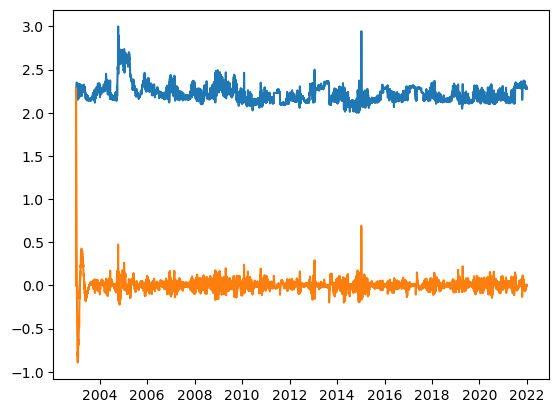

In [424]:
plt.plot(dsar_copy['HSR'])
plt.plot(filtered_dsar['HSR'])

In [223]:
df_dict

{2001:                      SEP  NED       YEL  VALT       HSR      EDM       SHW  \
 2001-01-01 00:00:00  NaN  NaN  1.359095   NaN  2.283112  2.83977  3.249168   
 2001-01-01 00:10:00  NaN  NaN  1.359095   NaN  2.283112  2.83977  3.249168   
 2001-01-01 00:20:00  NaN  NaN  1.359095   NaN  2.283112  2.83977  3.249669   
 2001-01-01 00:30:00  NaN  NaN  1.359095   NaN  2.283112  2.83977  3.249669   
 2001-01-01 00:40:00  NaN  NaN  1.359095   NaN  2.283155  2.83977  3.249669   
 ...                  ...  ...       ...   ...       ...      ...       ...   
 2001-12-31 23:10:00  NaN  NaN       NaN   NaN       NaN      NaN       NaN   
 2001-12-31 23:20:00  NaN  NaN       NaN   NaN       NaN      NaN       NaN   
 2001-12-31 23:30:00  NaN  NaN       NaN   NaN       NaN      NaN       NaN   
 2001-12-31 23:40:00  NaN  NaN       NaN   NaN       NaN      NaN       NaN   
 2001-12-31 23:50:00  NaN  NaN       NaN   NaN       NaN      NaN       NaN   
 
                          STD       SOS  JUN

In [221]:
df_all_new_old = df_all_new.copy()

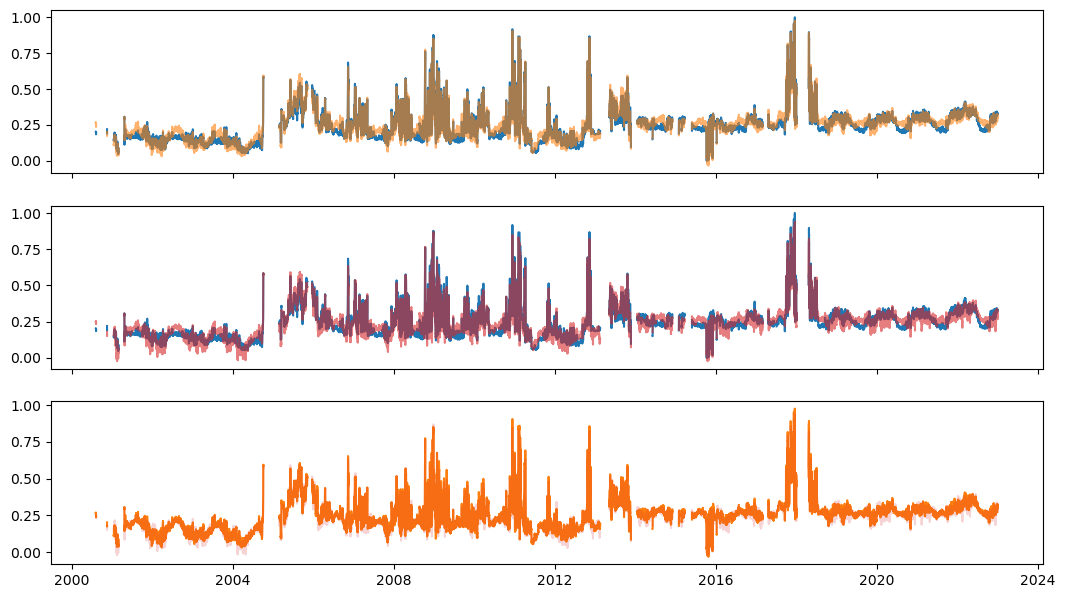

In [251]:
sta = 'SEP'

fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(6.4*2, 4.8*1.5))

ax1.plot(df_dsar_median[sta], color='C0')
ax1.plot(df_all_new_old[sta], color='C1', alpha=0.6)

ax2.plot(df_dsar_median[sta], color='C0')
ax2.plot(df_all_new[sta], color='C3', alpha=0.6)


ax3.plot(df_all_new_old[sta], color='C1')
ax3.plot(df_all_new[sta], color='C3', alpha=0.2)

<AxesSubplot:>

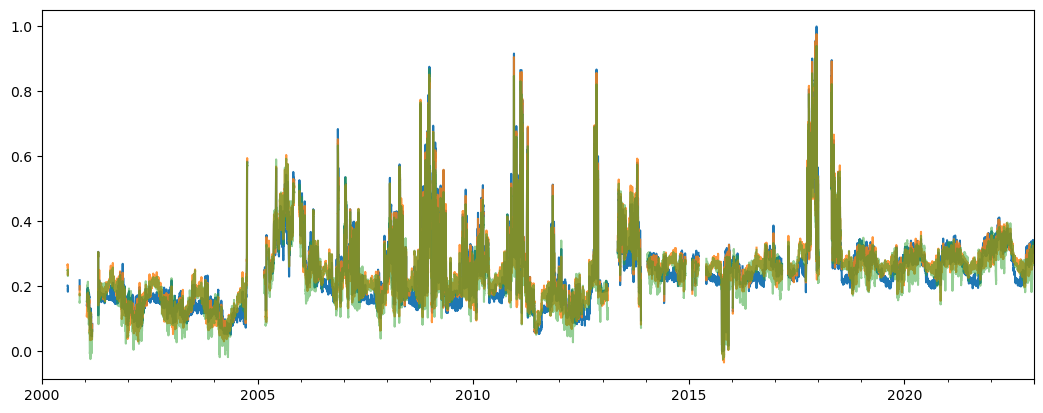

In [246]:
df_dsar_median['SEP'].plot(figsize=(6.4*2, 4.8))
df_all_new_old['SEP'].plot(figsize=(6.4*2, 4.8),alpha=0.8)
df_all_new['SEP'].plot(figsize=(6.4*2, 4.8),alpha=0.5)

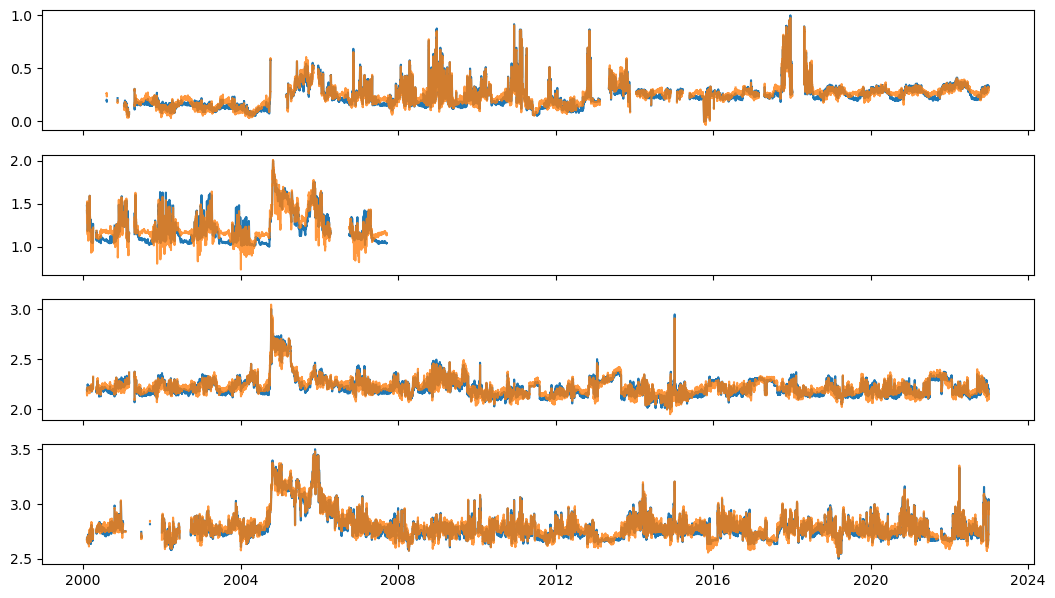

In [215]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex=True, figsize=(6.4*2, 4.8*1.5))
ax1.plot(df_dsar_median.SEP)
ax1.plot(df_all_new.SEP, alpha=0.8)

ax2.plot(df_dsar_median.YEL)
ax2.plot(df_all_new.YEL, alpha=0.8)

ax3.plot(df_dsar_median.HSR)
ax3.plot(df_all_new.HSR, alpha=0.8)

ax4.plot(df_dsar_median.EDM)
ax4.plot(df_all_new.EDM, alpha=0.8)

In [115]:
df_copy = d['2004'].copy()
df_copy1 = df_copy[df_copy.index<datetime.datetime(2004,2,29)]
df_copy2 = df_copy[df_copy.index>datetime.datetime(2004,3,1)]
df_copy = pd.concat([df_copy1, df_copy2])
df_copy.loc[datetime.datetime(2004,2,28,23):datetime.datetime(2004,3,1,1)]

,SEP,NED,YEL,VALT,HSR,EDM,SHW,STD,SOS,JUN,JRO,FL2,CDF,ELK,TDL
2004-02-28 23:00:00,0.156192,NaN,1.028417,NaN,2.287104,2.658125,3.254493,3.877651,4.173893,4.581086,NaN,5.642123,6.184627,6.632413,7.189602
2004-02-28 23:10:00,0.156192,NaN,1.028417,NaN,2.287793,2.657852,3.254493,3.877819,4.172179,4.581086,NaN,5.622493,6.184235,6.632413,7.189476
2004-02-28 23:20:00,0.156192,NaN,1.028417,NaN,2.287793,2.657825,3.254537,3.878173,4.171300,4.581086,NaN,5.607528,6.183602,6.632413,7.189366
2004-02-28 23:30:00,0.156192,NaN,1.028417,NaN,2.288262,2.657055,3.254580,3.878437,4.171160,4.581086,NaN,5.607439,6.183360,6.632413,7.189307
2004-02-28 23:40:00,0.156192,NaN,1.028417,NaN,2.288730,2.656284,3.254580,3.878515,4.171021,4.581086,NaN,5.607439,6.183226,6.632406,7.189274
2004-02-28 23:50:00,0.156192,NaN,1.028417,NaN,2.289081,2.656284,3.254580,3.878515,4.171021,4.581086,NaN,5.607439,6.183054,6.632365,7.189256
2004-03-01 00:10:00,0.122008,NaN,1.025122,NaN,2.298457,2.637752,3.255313,3.883939,4.159595,4.583737,NaN,5.570935,6.190115,6.615336,7.084096
2004-03-01 00:20:00,0.121599,NaN,1.025122,NaN,2.298457,2.637752,3.255313,3.883939,4.159127,4.583945,NaN,5.570935,6.190115,6.615336,7.084096
2004-03-01 00:30:00,0.121026,NaN,1.025122,NaN,2.298457,2.637752,3.255313,3.883939,4.159043,4.584153,NaN,5.570935,6.190115,6.615336,7.084096
2004-03-01 00:40:00,0.120568,NaN,1.025122,NaN,2.298457,2.637752,3.255313,3.883939,4.158901,4.584190,NaN,5.570935,6.190115,6.615336,7.084096


In [114]:
df_copy

,SEP,NED,YEL,VALT,HSR,EDM,SHW,STD,SOS,JUN,JRO,FL2,CDF,ELK,TDL


In [91]:
df_copy = df_dsar_median.copy()

df_copy.index = pd.Timedf_copy.index-df_copy.index.year
df_copy

TypeError: Addition/subtraction of integers and integer-arrays with DatetimeArray is no longer supported.  Instead of adding/subtracting `n`, use `n * obj.freq`

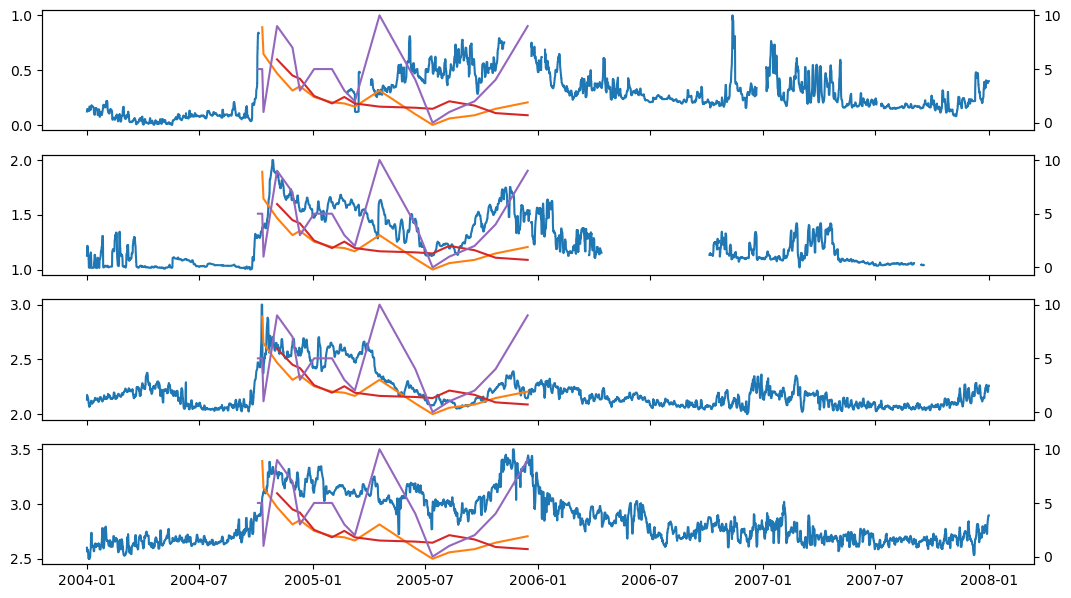

In [47]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex=True, figsize=(6.4*2, 4.8*1.5))

ax11 = ax1.twinx()
ax1.plot(df_dsar_median.SEP)
ax11.plot(df_dome.iloc[:,1], color='C1')
ax11.plot(df_dome.iloc[:,3], color='C3')
ax11.plot(df_dome.iloc[:,4], color='C4')

ax22 = ax2.twinx()
ax2.plot(df_dsar_median.YEL)
ax22.plot(df_dome.iloc[:,1], color='C1')
ax22.plot(df_dome.iloc[:,3], color='C3')
ax22.plot(df_dome.iloc[:,4], color='C4')

ax33 = ax3.twinx()
ax3.plot(df_dsar_median.HSR)
ax33.plot(df_dome.iloc[:,1], color='C1')
ax33.plot(df_dome.iloc[:,3], color='C3')
ax33.plot(df_dome.iloc[:,4], color='C4')

ax44 = ax4.twinx()
ax4.plot(df_dsar_median.EDM)
ax44.plot(df_dome.iloc[:,1], color='C1')
ax44.plot(df_dome.iloc[:,3], color='C3')
ax44.plot(df_dome.iloc[:,4], color='C4')

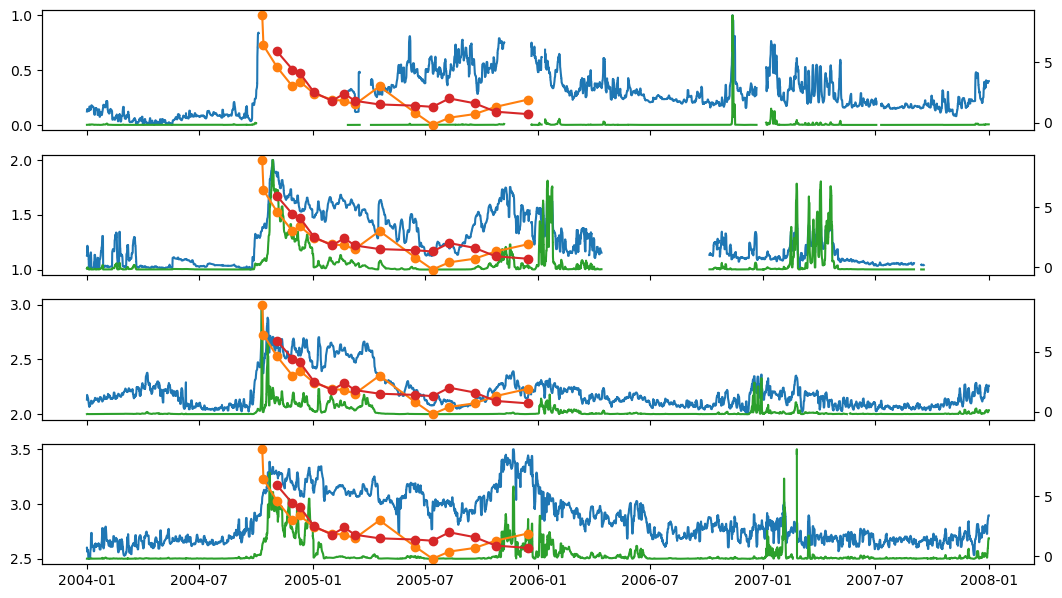

In [62]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex=True, figsize=(6.4*2, 4.8*1.5))

ax11 = ax1.twinx()
ax1.plot(df_dsar_median.SEP)
ax1.plot(df_zscdsar_median.SEP, color='C2')
ax11.plot(df_dome.iloc[:,1], color='C1', marker='o')
ax11.plot(df_dome.iloc[:,3], color='C3', marker='o')

ax22 = ax2.twinx()
ax2.plot(df_dsar_median.YEL)
ax2.plot(df_zscdsar_median.YEL, color='C2')
ax22.plot(df_dome.iloc[:,1], color='C1', marker='o')
ax22.plot(df_dome.iloc[:,3], color='C3', marker='o')

ax33 = ax3.twinx()
ax3.plot(df_dsar_median.HSR)
ax3.plot(df_zscdsar_median.HSR, color='C2')
ax33.plot(df_dome.iloc[:,1], color='C1', marker='o')
ax33.plot(df_dome.iloc[:,3], color='C3', marker='o')

ax44 = ax4.twinx()
ax4.plot(df_dsar_median.EDM)
ax4.plot(df_zscdsar_median.EDM, color='C2')
ax44.plot(df_dome.iloc[:,1], color='C1', marker='o')
ax44.plot(df_dome.iloc[:,3], color='C3', marker='o')

(12418.0, 13879.0)

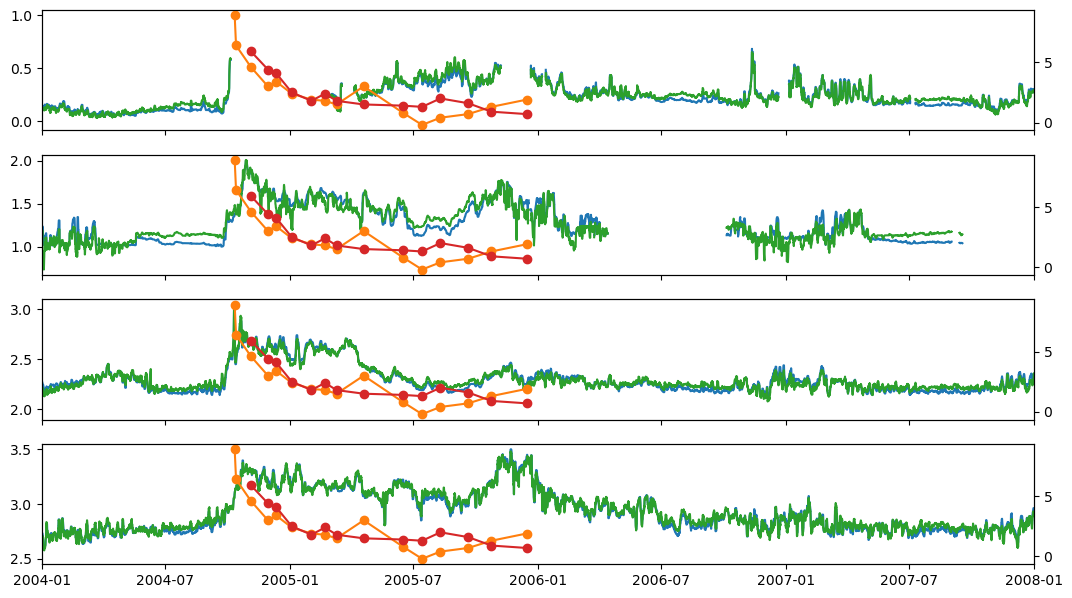

In [219]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex=True, figsize=(6.4*2, 4.8*1.5))

ax11 = ax1.twinx()
ax1.plot(df_dsar_median.SEP)
ax1.plot(df_all_new.SEP,color='C2')
# ax1.plot(df_zscdsar_median.SEP, color='C2')
ax11.plot(df_dome.iloc[:,1], color='C1', marker='o')
ax11.plot(df_dome.iloc[:,3], color='C3', marker='o')

ax22 = ax2.twinx()
ax2.plot(df_dsar_median.YEL)
ax2.plot(df_all_new.YEL,color='C2')
# ax2.plot(df_zscdsar_median.YEL, color='C2')
ax22.plot(df_dome.iloc[:,1], color='C1', marker='o')
ax22.plot(df_dome.iloc[:,3], color='C3', marker='o')

ax33 = ax3.twinx()
ax3.plot(df_dsar_median.HSR)
ax3.plot(df_all_new.HSR,color='C2')
# ax3.plot(df_zscdsar_median.HSR, color='C2')
ax33.plot(df_dome.iloc[:,1], color='C1', marker='o')
ax33.plot(df_dome.iloc[:,3], color='C3', marker='o')

ax44 = ax4.twinx()
ax4.plot(df_dsar_median.EDM)
ax4.plot(df_all_new.EDM,color='C2')
# ax4.plot(df_zscdsar_median.EDM, color='C2')
ax44.plot(df_dome.iloc[:,1], color='C1', marker='o')
ax44.plot(df_dome.iloc[:,3], color='C3', marker='o')


ax4.set_xlim(datetime.datetime(2004,1,1), datetime.datetime(2008,1,1))

(12662.0, 13149.0)

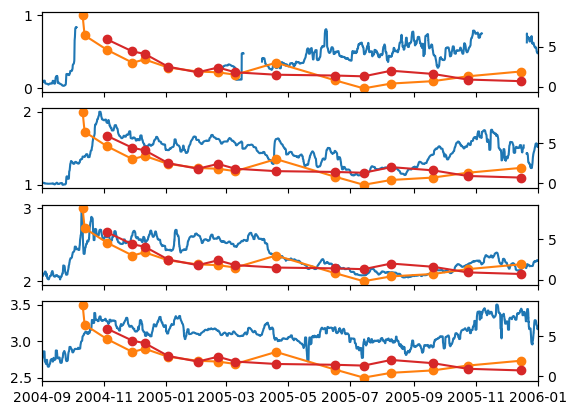

In [57]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex=True, figsize=(6.4, 4.8))

ax11 = ax1.twinx()
ax1.plot(df_dsar_median.SEP)
ax11.plot(df_dome.iloc[:,1], color='C1', marker='o')
ax11.plot(df_dome.iloc[:,3], color='C3', marker='o')

ax22 = ax2.twinx()
ax2.plot(df_dsar_median.YEL)
ax22.plot(df_dome.iloc[:,1], color='C1', marker='o')
ax22.plot(df_dome.iloc[:,3], color='C3', marker='o')

ax33 = ax3.twinx()
ax3.plot(df_dsar_median.HSR)
ax33.plot(df_dome.iloc[:,1], color='C1', marker='o')
ax33.plot(df_dome.iloc[:,3], color='C3', marker='o')

ax44 = ax4.twinx()
ax4.plot(df_dsar_median.EDM)
ax44.plot(df_dome.iloc[:,1], color='C1', marker='o')
ax44.plot(df_dome.iloc[:,3], color='C3', marker='o')

ax4.set_xlim(datetime.datetime(2004,9,1), datetime.datetime(2006,1,1))

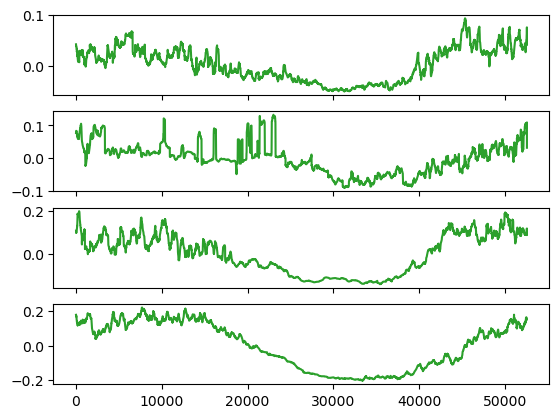

In [444]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex=True, figsize=(6.4, 4.8))
ax1.plot(stack[:,0],color='C2')
ax2.plot(stack[:,1],color='C2')
ax3.plot(stack[:,2],color='C2')
ax4.plot(stack[:,3],color='C2')

In [440]:
stack[:,0].shape

(52559,)

# Work with the _long files

In [446]:
df_SEP = pd.read_csv('../RSAM_DSAR/data/{}_extended2_long2.csv'.format('SEP'))
df_YEL_VALT = pd.read_csv('../RSAM_DSAR/data/{}_extended2_long2.csv'.format('YEL_VALT'))
df_HSR = pd.read_csv('../RSAM_DSAR/data/{}_extended2_long2.csv'.format('HSR'))
df_EDM = pd.read_csv('../RSAM_DSAR/data/{}_extended2_long2.csv'.format('EDM'))